In [127]:
from astropy.coordinates import Angle, SkyCoord, EarthLocation, AltAz, get_body, ICRS
import astropy.constants as c
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import WCSAxes

from astroquery.hips2fits import hips2fits
hips2fits.timeout = 300 # Necessary to prevent timeouts for downloading large files

from matplotlib import patheffects
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import os

from regions import Regions, PolygonSkyRegion

%matplotlib widget

hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
global hatch_idx
hatch_idx = 0

In [128]:
def wrap360(ang):
    return ((ang + 360.) % 360.)

In [129]:
EL_MIN = 20
EL_MAX = 52
DAZ_MIN = 90
DAZ_MAX = 225
az_limleft = lambda x: wrap360(x - 270)
az_limright = lambda x: wrap360(x - 135)


mcmurdo = EarthLocation(lat='-77.8419', lon='166.6863', height=37000.)
# mcmurdo = EarthLocation(lat='-77.8419', lon='346.6863', height=37000.) # halfway around continent
launch_date = Time('2026-12-25 00:00:00', scale='utc', location=mcmurdo)

step_hr = 1
oneday = np.arange(0, 24 + step_hr, step_hr) * u.hr
oneweek = np.arange(0, 24 * 7 + step_hr, step_hr) * u.hr
threeweeks = np.arange(24 * 7 * 3 + step_hr, step_hr) * u.hr
times = launch_date + oneday
t = (times - times[0]).to(u.hr)

sun_body = get_body('sun', times, location=mcmurdo)
sun = SkyCoord(ra=sun_body.ra, dec=sun_body.dec, obstime=times, location=mcmurdo)
sun_altaz = sun.transform_to('altaz')

gal_center = SkyCoord(ra='17h45m40.04s', dec='-29d00m28.s', obstime=times[0], location=mcmurdo)

goods_s = SkyCoord(ra=3.*15*u.degree,dec=-27*u.degree, obstime=times, location=mcmurdo)
goods_s_altaz = goods_s.transform_to('altaz')

edfs = SkyCoord(ra='04h04m57.84s', dec='-48d25m22.8s', obstime=times[0], location=mcmurdo)

edff = SkyCoord(ra='03h31m43.6s', dec='-28d05m18.6s', obstime=times[0], location=mcmurdo)

In [160]:
def plot_from_catalog_helper_t_vs_el(ax, name, skycoord_override=None):
    global hatch_idx
    if not skycoord_override:
        foo = SkyCoord.from_name(name)
        coord = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
    else:
        coord = skycoord_override
    foo_altaz = coord.transform_to(AltAz)
    l, = ax.plot(t, foo_altaz.alt.deg, marker='.', label=name)

    in_bounds = np.where((foo_altaz.alt.deg >= EL_MIN) & (foo_altaz.alt.deg <= EL_MAX))[0]
    for i0, i1 in zip(range(len(t))[:-1], range(len(t))[1:]):
        if (i0 in in_bounds) and (i1 in in_bounds):
            ax.axvspan(t[i0].value, t[i1].value, alpha=0.2, color=l.get_color(), hatch=hatches[hatch_idx])
    hatch_idx += 1
    return coord, foo_altaz


def plot_from_catalog_helper_t_vs_delta_sun(ax, name, skycoord_override=None):
    global hatch_idx
    if not skycoord_override:
        foo = SkyCoord.from_name(name)
        coord = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
    else:
        coord = skycoord_override
    foo_altaz = coord.transform_to(AltAz)

    sun_body = get_body('sun', times, location=mcmurdo)
    sun = SkyCoord(ra=sun_body.ra, dec=sun_body.dec, obstime=times, location=mcmurdo)
    sun_altaz = sun.transform_to('altaz')

    delta_az = wrap360(foo_altaz.az.deg - sun_altaz.az.deg)
    l, = ax.plot(t, delta_az, marker='.', label=f'{name} Az - Sun Az')

    
    in_bounds = np.where((delta_az >= DAZ_MIN) & (delta_az <= DAZ_MAX))[0]
    for i0, i1 in zip(range(len(t))[:-1], range(len(t))[1:]):
        if (i0 in in_bounds) and (i1 in in_bounds):
            ax.axvspan(t[i0].value, t[i1].value, alpha=0.2, color=l.get_color(), hatch=hatches[hatch_idx])
    hatch_idx += 1
    return coord, foo_altaz, sun_altaz

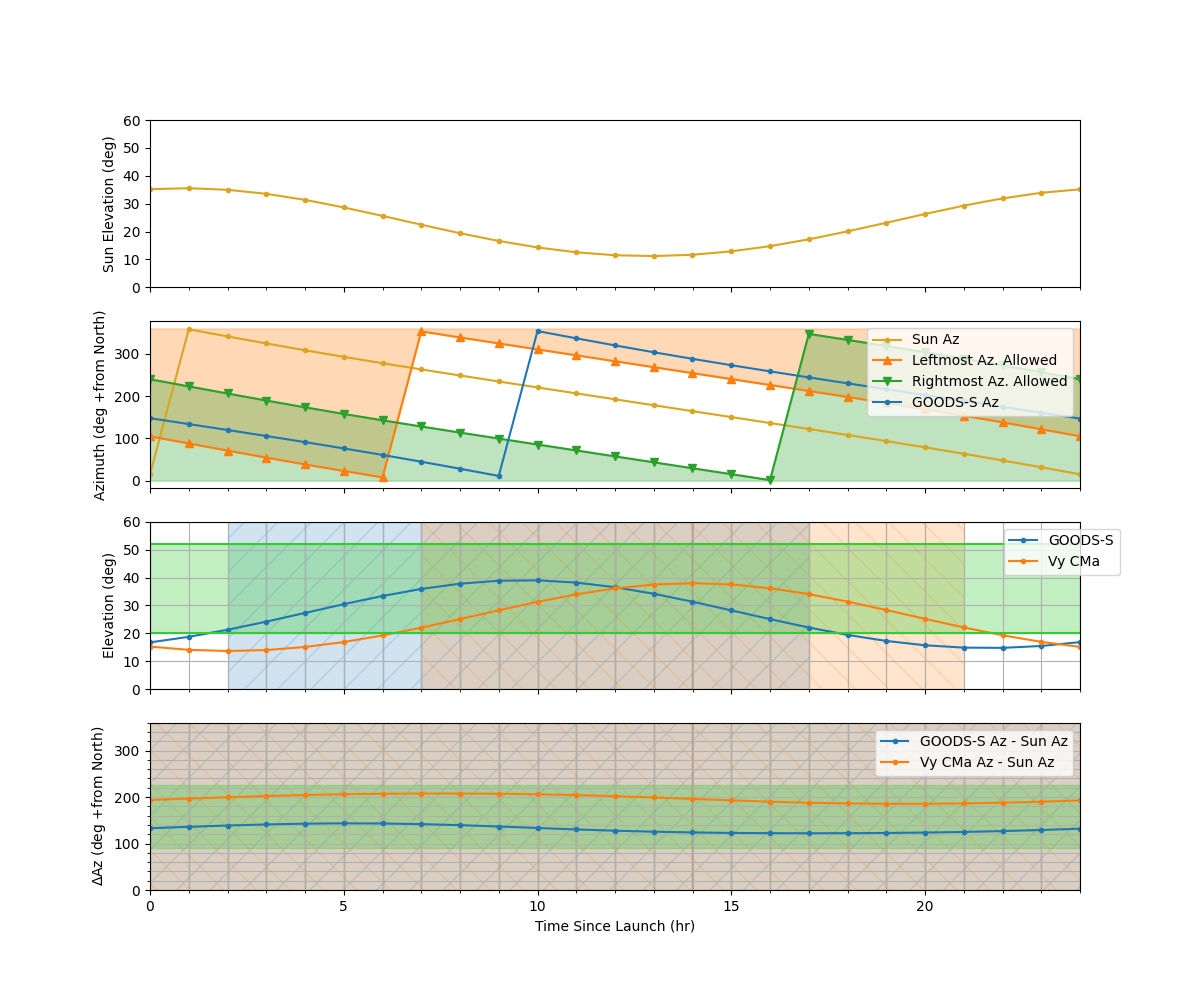

In [161]:
fig, ax = plt.subplots(figsize=(12,10), nrows=4, sharex=True)

ax[0].plot(t, sun_altaz.alt.deg, marker='.', color='goldenrod')
ax[0].set_ylim(0, 60)
ax[0].set_ylabel('Sun Elevation (deg)')

ax[1].plot(t, sun_altaz.az.deg, marker='.', color='goldenrod', label='Sun Az')
ax[1].plot(t, az_limleft(sun_altaz.az.deg), marker='^', color='C1', label='Leftmost Az. Allowed')
ax[1].fill_between(t.value, az_limleft(sun_altaz.az.deg), color='C1', y2=360, alpha=0.3)
ax[1].plot(t, az_limright(sun_altaz.az.deg), marker='v', color='C2', label='Rightmost Az. Allowed')
ax[1].fill_between(t.value, az_limright(sun_altaz.az.deg), color='C2', y2=0, alpha=0.3)
ax[1].plot(t, goods_s_altaz.az.deg, marker='.', label='GOODS-S Az')
ax[1].set_ylabel('Azimuth (deg +from North)')
ax[1].legend(loc='upper right')

hatch_idx = 0
plot_from_catalog_helper_t_vs_el(ax[2], 'GOODS-S', skycoord_override=goods_s)
plot_from_catalog_helper_t_vs_el(ax[2], 'Vy CMa')
# rcw19, _, = plot_from_catalog_helper_t_vs_el(ax[2], 'RCW 19')
# rcw20, _ = plot_from_catalog_helper_t_vs_el(ax[2], 'RCW 20')
# rcw36, _ = plot_from_catalog_helper_t_vs_el(ax[2], 'RCW 36')
# rcw38, _ = plot_from_catalog_helper_t_vs_el(ax[2], 'RCW 38')
# plot_from_catalog_helper_t_vs_el(ax[2], 'NGC 253')
# plot_from_catalog_helper_t_vs_el(ax[2], '[MHL2007] G259.0453-01.5559 1')
# plot_from_catalog_helper_t_vs_el(ax[2], 'IRAS 08088-3554')
# plot_from_catalog_helper_t_vs_el(ax[2], 'CG 30')
# plot_from_catalog_helper_t_vs_el(ax[2], 'IRAS 08448-4343')

ax[2].axhline(EL_MIN, color='limegreen')
ax[2].fill_between(t.value, EL_MIN, y2=EL_MAX, color='limegreen', alpha=0.3)
ax[2].axhline(EL_MAX, color='limegreen')
ax[2].set_ylim(0, 60)
ax[2].set_ylabel('Elevation (deg)')
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper right')
ax[2].grid(which='both')
ax[2].set_xlim(t[0].value, t[-1].value)

hatch_idx = 0
plot_from_catalog_helper_t_vs_delta_sun(ax[3], 'GOODS-S', skycoord_override=goods_s)
plot_from_catalog_helper_t_vs_delta_sun(ax[3], 'Vy CMa')
# plot_from_catalog_helper_t_vs_delta_sun(ax[3], 'RCW 19')
# plot_from_catalog_helper_t_vs_delta_sun(ax[3], 'RCW 36')
# plot_from_catalog_helper_t_vs_delta_sun(ax[3], 'RCW 38')

ax[3].fill_between(t.value, DAZ_MIN, y2=DAZ_MAX, color='limegreen', alpha=0.3)
ax[3].set_ylabel('$\Delta$Az (deg +from North)')
ax[3].legend(loc='upper right')
ax[3].grid(which='both')
ax[3].set_ylim(0, 360)
ax[3].set_xlabel('Time Since Launch (hr)')

plt.minorticks_on()

In [ ]:
def altaz_to_radec_helper(alt, az):
    my_radec = SkyCoord(
        AltAz(
            alt=alt,
            az=az,
            obstime=times,
            location=mcmurdo
        )
    ).transform_to(ICRS)
    return my_radec

In [ ]:
def plot_from_catalog_helper(ax, name):
    foo = SkyCoord.from_name(name)
    coord = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
    ax.scatter(coord.ra, coord.dec, edgecolor='k', transform=ax.get_transform('icrs'), label=name)

Plot a polygon on sky connecting the RA/Dec coordinates dictated by the el axis limits and the sun. One polygon per time coordinate

In [ ]:
def allsky_query(hips, reload=False):
    fname = hips.replace('/', '_') + '.fits'
    if os.path.exists(fname) and reload:
        result = hips2fits.query(
            hips=hips,
            ra=0 * u.deg,
            dec=0 * u.deg,
            width=5000,
            height=2500,
            fov=360 * u.deg,
            projection='MOL',
            get_query_payload=False,
            format='fits',
        )
        result.writeto(fname, overwrite=True)

    hdu = fits.open(fname)
    h = hdu[0].header
    wcs = WCS(h, naxis=2) # reduce WCS dimensionality for polygon overplot
    d = hdu[0].data
    return wcs, h, d

In [ ]:
# https://alasky.cds.unistra.fr/hips-image-services/hips2fits
wcs, h, d0 = allsky_query('CDS/P/IRIS/color', reload=False)
d0 = d0[2,:,:]

In [ ]:
wcs, h, d1 = allsky_query('ESAVO/P/HERSCHEL/SPIRE-350', reload=False)

In [ ]:
ds = [d1, d0]

Text(0.5, 0.98, 'Observing Time: 1.0 days')

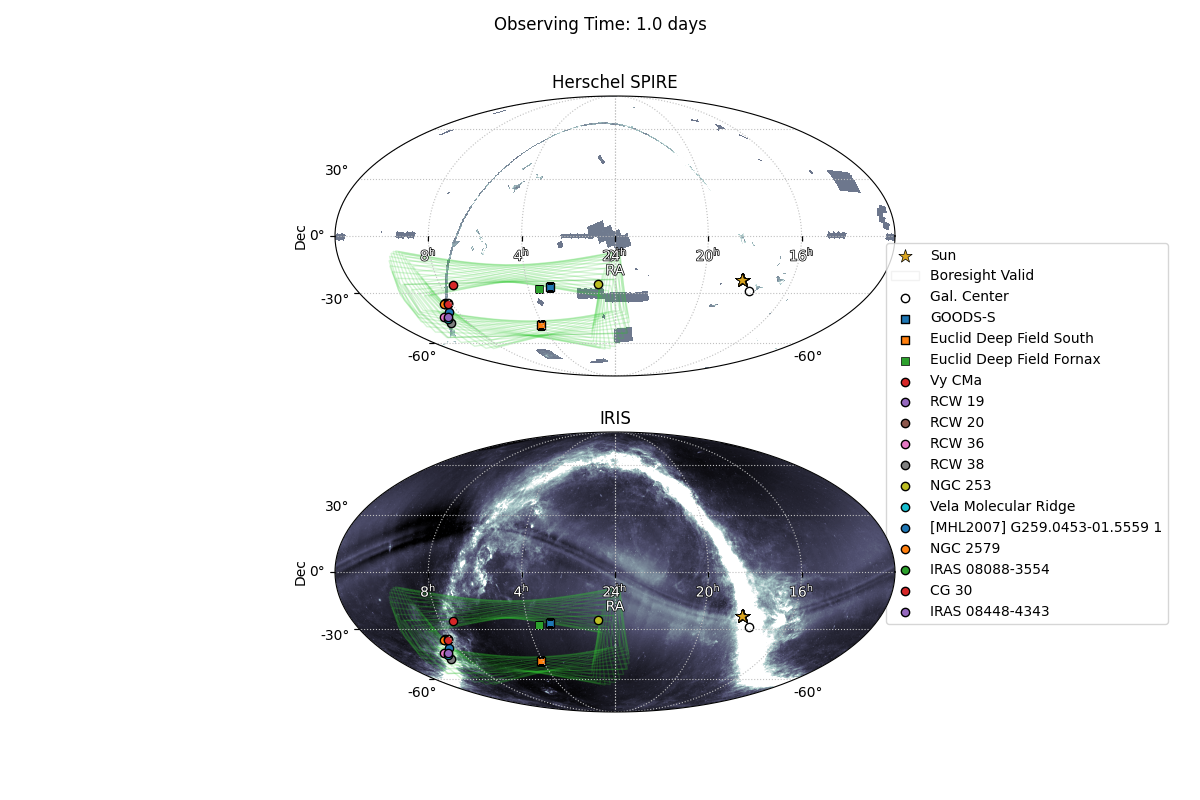

In [ ]:
fig, axs = plt.subplots(figsize=(12,8), nrows=2, subplot_kw=dict(projection=wcs, frame_class=EllipticalFrame), sharex=True, sharey=True)
ax0, ax1 = axs

for j, ax in enumerate(axs):
    d = ds[j]

    lon = ax.coords[0]
    lat = ax.coords[1]
    lat.set_axislabel_position("c")

    path_effects=[patheffects.withStroke(linewidth=1, foreground='black')]
    lon.set_ticklabel(color='white', path_effects=path_effects)
    ax.grid(linestyle=':', color='silver')

    ax.imshow(d, vmin=np.nanmin(d), vmax=np.nanmean(d) + 1 * np.nanstd(d), cmap='bone')

    p = ax.scatter(sun.ra, sun.dec, s=100, marker='*', facecolor='goldenrod', edgecolor='k', linewidth=.5, transform=ax.get_transform('icrs'), label='Sun')

    limleftup_radec = altaz_to_radec_helper(EL_MAX * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limleftmid_radec = altaz_to_radec_helper((EL_MAX + EL_MIN)/2 * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limleftdown_radec = altaz_to_radec_helper(EL_MIN * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limrightup_radec = altaz_to_radec_helper(EL_MAX * u.deg, az_limright(sun_altaz.az.deg) * u.deg)
    limrightmid_radec = altaz_to_radec_helper((EL_MAX + EL_MIN)/2 * u.deg, az_limright(sun_altaz.az.deg) * u.deg)
    limrightdown_radec = altaz_to_radec_helper(EL_MIN * u.deg, az_limright(sun_altaz.az.deg) * u.deg)

    # coordinates of corners on plot
    # p = ax.scatter(limleftup_radec.ra, limleftup_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limleftmid_radec.ra, limleftmid_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limleftdown_radec.ra, limleftdown_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightup_radec.ra, limrightup_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightmid_radec.ra, limrightmid_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightdown_radec.ra, limrightdown_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))

    rs = []
    for i in range(len(limleftup_radec)):
        verts = SkyCoord([
                limleftup_radec.ra[i],
                limleftmid_radec.ra[i],
                limleftdown_radec.ra[i],
                limrightdown_radec.ra[i],
                limrightmid_radec.ra[i],
                limrightup_radec.ra[i],
            ],
            [
                limleftup_radec.dec[i],
                limleftmid_radec.dec[i],
                limleftdown_radec.dec[i],
                limrightdown_radec.dec[i],
                limrightmid_radec.dec[i],
                limrightup_radec.dec[i],
            ],
            unit='deg',
            frame=ICRS
        )
        reg = PolygonSkyRegion(vertices=verts, visual=dict(fill=True, edgecolor='limegreen', facecolor=None))
        rs.append(reg)
    regions = Regions(rs)
    regions.write('myregions.reg', format='ds9', overwrite=True)

    px_regions = [r.to_pixel(wcs) for r in rs]
    for i, p in enumerate(px_regions):
        if i == 0:
            p.plot(ax=ax, edgecolor='k', facecolor='none', alpha=max(1/len(times), 0.05), label='Boresight Valid')
        # p.plot(ax=ax, edgecolor='k', alpha=max(1/len(times), 0.01))
        p.plot(ax=ax, facecolor='none', edgecolor='limegreen', alpha=0.2)

    # some additional points of interest
    ax.scatter(gal_center.ra, gal_center.dec, facecolor='w', edgecolor='k', transform=ax.get_transform('icrs'), label='Gal. Center')
    ax.scatter(goods_s.ra, goods_s.dec, marker='s', edgecolor='k', transform=ax.get_transform('icrs'), label='GOODS-S')
    ax.scatter(edfs.ra, edfs.dec, marker='s', edgecolor='k', transform=ax.get_transform('icrs'), label='Euclid Deep Field South')
    ax.scatter(edff.ra, edff.dec, marker='s', linewidth=0.5, edgecolor='k', transform=ax.get_transform('icrs'), label='Euclid Deep Field Fornax')

    plot_from_catalog_helper(ax, 'Vy CMa')
    plot_from_catalog_helper(ax, 'RCW 19')
    plot_from_catalog_helper(ax, 'RCW 20')
    plot_from_catalog_helper(ax, 'RCW 36')
    plot_from_catalog_helper(ax, 'RCW 38')
    # plot_from_catalog_helper(ax, 'RCW 42')
    # plot_from_catalog_helper(ax, 'RCW 49')
    # plot_from_catalog_helper(ax, 'Carina Nebula')
    plot_from_catalog_helper(ax, 'NGC 253')
    # plot_from_catalog_helper(ax, 'NGC 3576')
    # plot_from_catalog_helper(ax, 'NGC 3603')
    plot_from_catalog_helper(ax, 'Vela Molecular Ridge')
    # plot_from_catalog_helper(ax, 'Beta Gruis')
    plot_from_catalog_helper(ax, '[MHL2007] G259.0453-01.5559 1') # Young Stellar Object Candidate
    plot_from_catalog_helper(ax, 'NGC 2579')
    plot_from_catalog_helper(ax, 'IRAS 08088-3554')
    plot_from_catalog_helper(ax, 'CG 30')
    plot_from_catalog_helper(ax, 'IRAS 08448-4343')

    # for hh in [120, 132, 133, 171, 188, 217, 219, 246]: # [46, 47, 72, 73, 74, 75,]
    #     plot_from_catalog_helper(ax, 'HH' + str(hh))

    ax.set_xlabel('RA', color='w', path_effects=path_effects)
    ax.set_ylabel('Dec')
    if j == 0:
        ax.legend(bbox_to_anchor=(1.5, 0.5))
    # fig.tight_layout()

ax0.set_title('Herschel SPIRE')
ax1.set_title('IRIS')
fig.suptitle(f'Observing Time: {(t[-1] - t[0]).to(u.day).value:.1f} days')

astroplan constraints

In [ ]:
from astroplan import Observer, FixedTarget, Constraint, AltitudeConstraint, SunSeparationConstraint
from astroplan import is_observable, is_always_observable, months_observable
from astroplan.plots import plot_sky

In [ ]:
ldb = (-77.861 * u.deg, 167.061 * u.deg)

# ground track:
# Salter Test Flight Universal completed ~1 circuit in 11 days, 6 hr, 57 min. Average the longitudinal velocity.
# Really, ballons have a spatial velocity, so this constant lat assumption is an oversimplification.
dlon_dt = (360 * u.deg / (11 * u.day + 6 * u.hr + 57 * u.min)).to(u.deg / u.hr)
lon = ldb[1] + dlon_dt * t
lat = np.ones_like(lon.value) * ldb[0]

In [ ]:
class SunRelativeAzConstraint(Constraint):
    pass

In [ ]:
tim = Observer(longitude=lon[0], latitude=lat[0], elevation=37000 * u.km, name="TIM")
targets = [
    FixedTarget(coord=rcw19, name='RCW 19'),
    FixedTarget(coord=rcw36, name='RCW 36'),
    FixedTarget(coord=rcw38, name='RCW 38')
]
constraints = [
    AltitudeConstraint(20 * u.deg, 52 * u.deg),
    SunSeparationConstraint(min=110 * u.deg) # actually asymmetrical, but we will implement a custom constraint later.
]

In [ ]:
ever_observable = is_observable(constraints, tim, targets, time_range=(times[0], times[1]))
always_observable = is_always_observable(constraints, tim, targets, time_range=(times[0], times[1]))
ever_observable, always_observable

(array([ True, False, False]), array([ True, False, False]))

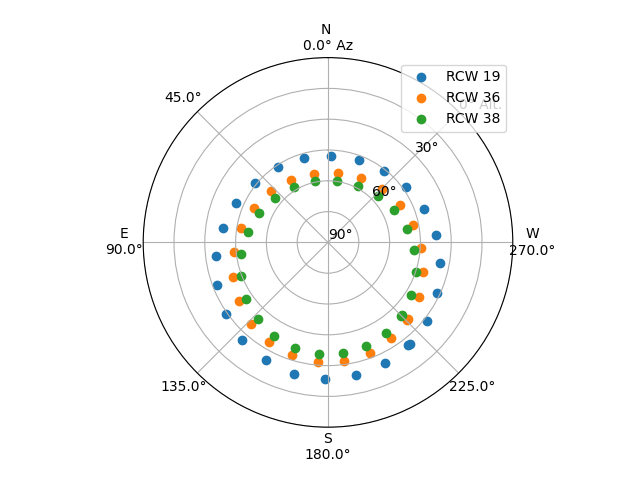

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

plot_sky(targets[0], tim, times, ax=ax)
plot_sky(targets[1], tim, times, ax=ax)
plot_sky(targets[2], tim, times, ax=ax)

ax.legend()